In [1]:
import tarfile,sys
import pandas as pd
import os
import re as regex
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Read data from csv files 

In [4]:
traindata = pd.read_csv('training_4.25')
testdata = pd.read_csv('testing_4.25')

In [5]:
b = pd.DataFrame(traindata['tweet'].str.split('####').tolist(), index=[traindata['user_name'], traindata['class']]).stack()
b = b.reset_index()[[0, 'user_name','class']] 
b.columns = ['tweet', 'user_name','class']
final_train_data = b

In [6]:
b = pd.DataFrame(testdata['tweet'].str.split('####').tolist(), index=[testdata['user_name'], testdata['class']]).stack()
b = b.reset_index()[[0, 'user_name','class']] 
b.columns = ['tweet', 'user_name','class']
final_test_data = b

## Clean Up Data

In [7]:
def remove_by_regex(tweets, regexp):
    tweets.loc[:, "tweet"].replace(regexp, "", inplace=True)
    return tweets

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

def remove_na(tweets):
    return tweets[tweets["tweet"] != "Not Available"] 

def remove_empty(tweets):
    return tweets[tweets["tweet"] != " "]

def remove_special_chars(tweets):  # it unrolls the hashtags to normal words
    for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                 "@", "%", "^", "*", "(", ")", "{", "}",
                                                                 "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                 "!", "?", ".", "'",
                                                                 "--", "---", "#"]):
        tweets.loc[:, "tweet"].replace(remove, "", inplace=True)
    return tweets

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [8]:
traindata = final_train_data
traindata = remove_urls(traindata)
traindata = remove_na(traindata)
traindata= remove_empty(traindata)
traindata = remove_usernames(traindata)
traindata = remove_special_chars(traindata)
traindata = remove_numbers(traindata)
#traindata.cleanup(TwitterCleanuper())

x = traindata.query('tweet != ""')
x.shape
traindata=x
traindata = traindata[traindata.tweet.str.split(' ').str.len() > 1]
traindata=traindata.reset_index(drop=True)

In [9]:
testdata = final_test_data
testdata = remove_urls(testdata)
testdata = remove_na(testdata)
testdata= remove_empty(testdata)
testdata = remove_usernames(testdata)
testdata = remove_special_chars(testdata)
testdata = remove_numbers(testdata)
#testdata.cleanup(TwitterCleanuper())

x = testdata.query('tweet != ""')
x.shape
testdata=x
testdata = testdata[testdata.tweet.str.split(' ').str.len() > 1]
testdata=testdata.reset_index(drop=True)

In [10]:
traindata.shape

(39979, 3)

In [11]:
testdata.shape

(9992, 3)

## Create tokenize, batchify, and copy state functions

In [12]:
def tokenize(tweet):
        # Tokenize file content
    ids = torch.ByteTensor(len(tweet.encode()))
    token = 0
    for char in tweet.encode():
        ids[token] = char
        token += 1

    return ids

def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data   

def copy_state(state):
    if isinstance(state, tuple):
    	return (Variable(state[0].data), Variable(state[1].data))
    else:
    	return Variable(state.data) 

## Build RNN Model

In [13]:
class Net(nn.Module):
    def __init__(self, features, cls_size):
        super(Net, self).__init__()
        self.hidden_size = 256
        self.embedding = nn.Embedding(features, self.hidden_size)
        self.rnn1 = nn.GRU(input_size=features,
                            hidden_size=self.hidden_size)
        self.dense1 = nn.Linear(self.hidden_size, cls_size)

    def forward(self, x, hidden):
        output, hidden = self.rnn1(x, hidden)
        #output = self.dense1(output)
        return output, hidden

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(1, batch_size, self.hidden_size).zero_())

def var(x):
    x = Variable(x)
    return x

embed = nn.Embedding(256, 50)    
embed_optimizer = optim.SGD(embed.parameters(), lr=0.005)

model = Net(features=50, cls_size=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
hiddens=[]
y=[]
rnn = model

## Train RNN Model

In [14]:
def train():
    hiddenCounter=0
    model.train()
    batch_size = 1
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    t0=time.time()
    for s in range(traindata.shape[0]):
        model.zero_grad()
        embed_optimizer.zero_grad()
        hidden = hidden_init
        loss =0
        tweet=traindata.loc[s].tweet
        emb = tokenize(tweet)
        embLen=len(emb)
        if (embLen>1):
            for i in range(embLen): 
                character1=Variable((torch.Tensor([emb[i]])).long())
                character1=embed(character1)
                character1=character1.view(1,1,50)

                output, hidden = model(character1, var(hidden.data))
                output=output.view(1,256)

                if i+1 < embLen: 
                    character2=Variable((torch.Tensor([emb[i+1]])).long())
                    loss += criterion(output, character2)
            #print (loss)
            loss.backward()
            tempHidden=hidden.view(256)
            tempHidden=list(tempHidden.data.numpy())
            hiddens.append(tempHidden)
            y.append(traindata['class'].loc[s])
            hidden_init = copy_state(hidden)
            optimizer.step()
            embed_optimizer.step()
            loss_avg = .99*loss_avg + .01*loss.data[0]/embLen

        if s % 10000 == 0:
            print(epoch, s, loss_avg)
            print (str(s)+' iterations ran, ''time elapsed= '+str((time.time()-t0)/60))

for epoch in range(1):
    print(model.parameters())
    hiddens=[]
    train()

<generator object Module.parameters at 0x7fae2c440888>
0 0 0.05487421094756765
0 iterations ran, time elapsed= 0.012838101387023926
0 10000 4.122448936878376
10000 iterations ran, time elapsed= 17.23893296321233
0 20000 4.141173252684175
20000 iterations ran, time elapsed= 33.27216882705689
0 30000 4.139236901346705
30000 iterations ran, time elapsed= 49.798169505596164


## Save Trained Model

In [15]:
import pickle
filename = '4.25_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [16]:
from sklearn.externals import joblib
import pickle
loaded_model = joblib.load(open('4.25_model.sav',"rb" ))

## Save Training Data from RNN

In [40]:
import csv
csvfile='trainHidden_4.25.csv'
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(hiddens)

outfile = open('trainY_4.25.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], y))
outfile.close()

## Classifiers and Cross Validation

In [17]:
crisisEncoder = LabelEncoder()
y = crisisEncoder.fit_transform(y)
print (crisisEncoder.classes_)

['control' 'depression' 'ptsd']


In [18]:
log = cross_val_score(LogisticRegression(), hiddens, y,cv=5)
print("Logisitic regression average accuracy : ",log.mean())

Logisitic regression average accuracy :  0.844167335719


In [19]:
nb = cross_val_score(GaussianNB(), hiddens, y,cv=5)
print("Naive bayes average accuracy : ",nb.mean())

Naive bayes average accuracy :  0.856722587982


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = cross_val_score(RandomForestClassifier(), hiddens, y,cv=5)
print("Random forest average accuracy : ",rf.mean())

Random forest average accuracy :  0.870298531805


In [27]:
# clf = RandomForestClassifier()
# clf.fit(hiddens, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
etrees = cross_val_score(ExtraTreesClassifier(), hiddens, y,cv=5)
print("Extra trees average accuracy : ",etrees.mean())

Extra trees average accuracy :  0.900090132678


In [22]:
forest = ExtraTreesClassifier()
forest.fit(hiddens, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
logreg = ExtraTreesClassifier()
logreg.fit(hiddens, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Testing the RNN Model

In [24]:
testHiddens=[]
testY=[]

def test():
    loaded_model.eval()
    batch_size = 1
    hidden_init = loaded_model.init_hidden(1)
    loss_avg = 0
    t0=time.time()
    for s in range(testdata.shape[0]):
        hidden = hidden_init
        loss =0
        tweet=testdata.loc[s].tweet
        emb = tokenize(tweet)
        embLen=len(emb)
        if (embLen>1):
            for i in range(embLen): 
                character1=Variable((torch.Tensor([emb[i]])).long())
                character1=embed(character1)
                character1=character1.view(1,1,50)

                output, hidden = loaded_model(character1, var(hidden.data))
                output=output.view(1,256)

                if i+1 < embLen: 
                    character2=Variable((torch.Tensor([emb[i+1]])).long())
                    loss += criterion(output, character2)
            #print (loss)
            tempHidden=hidden.view(256)
            tempHidden=list(tempHidden.data.numpy())
            testHiddens.append(tempHidden)
            testY.append(testdata['class'].loc[s])
            hidden_init = copy_state(hidden)
            loss_avg = .99*loss_avg + .01*loss.data[0]/embLen
            
            

for epoch in range(1):
    print(loaded_model.parameters())
    testHiddens=[]
    test()

<generator object Module.parameters at 0x7fad9d6db888>


## Saving output of testing to csv

In [39]:
import csv
csvfile='testHidden_4.25.csv'
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(testHiddens)
    
    
outfile = open('testY_4.25.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], testY))
outfile.close()

## Running model on testing data

In [25]:
crisisEncoder = LabelEncoder()
testY = crisisEncoder.fit_transform(testY)
print (crisisEncoder.classes_)

['control' 'depression' 'ptsd']


In [26]:
logreg = LogisticRegression()
logreg.fit(hiddens, y)
y_pred = logreg.predict(testHiddens)
print('Accuracy of classifier on test set: {:.2f}'.format(logreg.score(testHiddens, testY)))

Accuracy of classifier on test set: 0.50


In [27]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier()
forest.fit(hiddens, y)
y_pred = forest.predict(testHiddens)
print('Accuracy of classifier on test set: {:.2f}'.format(forest.score(testHiddens, testY)))

Accuracy of classifier on test set: 0.50


## Confusion Matrix

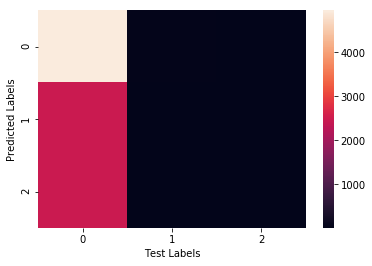

In [29]:
xcm=confusion_matrix(testY, y_pred, labels=None, sample_weight=None)
xcm=numpy.array(xcm)
ax = sns.heatmap(xcm)
plt.xlabel('Test Labels')
plt.ylabel('Predicted Labels')
#plt.show()
plt.savefig('ConfusionMatrix')

In [30]:
xcm

array([[4953,   31,   10],
       [2480,    8,   11],
       [2478,   13,    8]])

## Visualize Classification of Characters 

In [38]:
def visualize(data):
    hiddenCounter=0
    loaded_model.eval()
    batch_size = 1
    hidden_init = loaded_model.init_hidden(1)
    loss_avg = 0
    for s in range(1):

        hidden = hidden_init
        loss =0
        tweet=data
        chars=list(tweet)
        emb = tokenize(tweet)
        embLen=len(emb)
        for i in range(embLen): 
            character1=Variable((torch.Tensor([emb[i]])).long())
            letter=character1.data.numpy()
            character1=embed(character1)
            character1=character1.view(1,1,50)
            output, hidden = loaded_model(character1, var(hidden.data))
            
            temp=hidden.view(256)
            temp = temp.data.numpy()
            temp = temp.reshape(1,-1)
            #scales=logreg.predict_proba(temp)
            label=forest.predict(temp)
            if label==0: #control - green 
                text="\033[0;30;42m "+chars[i]
                print (text, end=" ")
            if label==1: #depressed - red
                text="\033[1;30;41m "+chars[i]
                print (text, end=" ")
            if label==2: #ptsd-blue
                text="\033[1;30;44m "+chars[i]
                print (text, end=" ")
            
            output=output.view(1,256)

            if i+1 < embLen: 
                character2=Variable((torch.Tensor([emb[i+1]])).long())
                loss += criterion(output, character2)

        hidden_init = copy_state(hidden)
        loss_avg = .99*loss_avg + .01*loss.data[0]/embLen
        
visualize('i do not want to be alive anymore')

 i     d  o     n  o  t     w  a  n  t     t  o     b  e     a  l  i  v  e     a  n  y  m  o  r  e 